In [281]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pytrends.request import TrendReq

from statsmodels.tsa.stattools import adfuller, kpss

# GDP data reading and cleaning

In [171]:
gdp_path = '../../data/expenditure/expenditure_gdp.csv'
gdp = pd.read_csv(gdp_path)
gdp['REF_DATE'] = pd.to_datetime(gdp['REF_DATE'])
gdp.head(2)

C:\Users\sidhu\AppData\Local\Temp/ipykernel_17144/2999133702.py:2: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  gdp = pd.read_csv(gdp_path)


,REF_DATE,GEO,DGUID,Prices,Seasonal adjustment,Estimates,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1961-01-01,Canada,2016A000011124,Chained (2012) dollars,Seasonally adjusted at annual rates,Final consumption expenditure,Dollars,81,millions,6,v62305723,1.1.1.1,273818.0,NaN,NaN,NaN,0
1,1961-01-01,Canada,2016A000011124,Chained (2012) dollars,Seasonally adjusted at annual rates,Household final consumption expenditure,Dollars,81,millions,6,v62305724,1.1.1.2,182300.0,NaN,NaN,NaN,0


### Extracted only required columns and rows

In [270]:
# filter data
gdp_subset = gdp[(gdp['REF_DATE'] >= '2004-01-01') &
                (gdp['Prices'] == 'Chained (2012) dollars') & 
                (gdp['Estimates'] == 'Gross domestic product at market prices') &
                 (gdp['UOM'] == 'Dollars')]
gdpts = gdp_subset[['REF_DATE', 'VALUE']]

# rename columns
gdpts = gdpts.rename(columns = {'REF_DATE': 'Date', 'VALUE': 'GDP'})
gdpts.index = gdpts['Date']
gdpts = gdpts.drop(columns = ['Date'])

In [271]:
gdpts.head()

,GDP
Date,
2004-01-01,1566737.0
2004-04-01,1585347.0
2004-07-01,1604061.0
2004-10-01,1615585.0
2005-01-01,1621176.0


### Time series of GDP

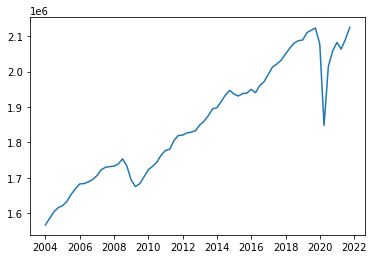

In [280]:
gdp_data = gdpts.copy()
plt.plot(gdp_data['GDP'])
plt.show()

### Growth rate of GDP

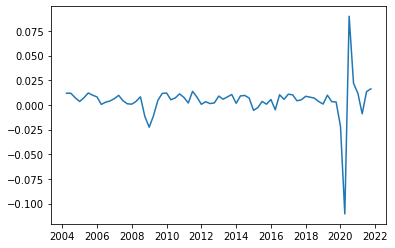

In [284]:
gdpts['GDP_GrowthRate'] = gdpts['GDP'].pct_change()
gdpts = gdpts.dropna()

plt.plot(gdpts['GDP_GrowthRate'])
plt.show()

### Check stationarity

In [316]:
# source link: https://www.statsmodels.org/devel/examples/notebooks/generated/stationarity_detrending_adf_kpss.html

def adf_test(timeseries):
    #print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    #print(dfoutput)
    if dftest[1] < 0.05:
        print("Series is stationary")
    else:
        print("Series is not stationary")


def kpss_test(timeseries):
    #print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    #print(kpss_output)
    if kptest[1] > 0.05:
        print("Series is stationary")
    else:
        print("Series is not stationary")

In [317]:
adf_test(gdpts['GDP_GrowthRate'])


Series is stationary


In [318]:
kstest = kpss_test(gdpts['GDP_GrowthRate'])

C:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


NameError: name 'kptest' is not defined

In [314]:
kstest[1]

0.1

# Get predictors from Google Trends

In [232]:
# get caegories and keywords from csv file
key_path = '../../data/keywords_data/GDP.csv'
key_data = pd.read_csv(key_path)
cat_lst = key_data['CatNo']                    # list of categories
keywords_lst = key_data['Keywords'].dropna()   # list of selected keywords
keyCat_lst = key_data['keywordCatNo'].astype('Int64').dropna()   # list of categories corresponding to keywords

In [233]:
pytrends = TrendReq(hl='en-US', backoff_factor=0.1)

# function to get google trend time series of respective


def get_trends(keyword=[''], category='0', related_queries=0, related_topics=0):
    """ function to get the google trend for desired keyword and category"""
    kw_list = keyword
    cat = category
    timeframe = '2004-01-01 2022-04-01'
    geo = 'CA'
    gprop = ''

    try:
        pytrends.build_payload(kw_list, cat, timeframe, geo, gprop)
        # get time series
        data = pytrends.interest_over_time()
    except:
        print(f"Category {cat} does not exist")
        return [''], [''], ['']

    # get related queries
    try:
        if related_queries > 0:
            queries = pytrends.related_queries()
            queries_lst = list(queries['']['top']['query'].values[0:related_queries])
        else:
            queries_lst = ['']
    except:
        queries_lst = ['']

    # get related topics
    try:
        if related_topics > 0:
            topics = pytrends.related_topics()
            topics_lst = list(topics['']['top']['topic_title'].values[0:related_topics])
        else:
            topics_lst = ['']
    except:
        topics_lst = ['']
    return data, queries_lst, topics_lst

In [216]:
# get dataframe of timeseries for categories

cat_queries_dict = {}
cat_topics_dict = {}

# get time series and related queries and topics of categories
for i, category in enumerate(cat_lst):
    category = str(category)
    data, queries, topics = get_trends(category=category, related_queries=2, related_topics=2)
    cat_queries_dict[category] = queries
    cat_topics_dict[category] = topics

    #Code to append data for different columns in data frame
    if i == 0:
        data.rename(columns = {'': category}, inplace = True)
        categoryts = data.drop(columns=['isPartial'])
    else:
        data.rename(columns = {'': category}, inplace = True)
        data = data.drop(columns=['isPartial'])
        categoryts = categoryts.join(data)

In [ ]:
# get dataframe of timeseries for keywords

keywords_queries_dict = {}
keywords_topics_dict = {}

# get time series and related queries and topics of selected keywords
for i, keyword in enumerate(keywords_lst[0:2]):
    category = str(keyCat_lst[i])
    data, queries, topics = get_trends(keyword = [keyword], category = category, related_queries=2, related_topics=2)
    keywords_queries_dict[category] = queries
    keywords_topics_dict[category] = topics

    #Code to append data for different columns in data frame
    if i == 0:
        keywordsts = data.drop(columns=['isPartial'])
    else:
        data = data.drop(columns=['isPartial'])
        keywordsts = keywordsts.join(data)

### Plot trends

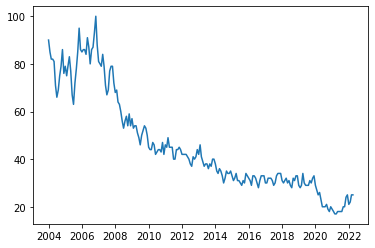

In [231]:
trend_data = categoryts.copy()
plt.plot(trend_data['23'])
plt.show()

In [12]:
pytrends.suggestions("Economic crisis")

[{'mid': '/g/1211cg58', 'title': 'economic crisis', 'type': 'Topic'},
 {'mid': '/g/11q2xlm4ss',
  'title': '2019–present Sri Lankan economic crisis',
  'type': 'Event'},
 {'mid': '/m/080pqzt',
  'title': '1998–1999 Ecuador economic crisis',
  'type': 'Topic'},
 {'mid': '/g/11bwdr23n9',
  'title': '2013–present economic crisis in Venezuela',
  'type': 'Topic'},
 {'mid': '/m/05p85kd',
  'title': '1991 Indian economic crisis',
  'type': 'Topic'}]